# Example
#### Model: MLP
#### Data: MNIST (1,7) classes
#### 10% switch labels rate

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import pytorch_lightning as pl

class BinaryMNISTClassifier(pl.LightningModule):
    def __init__(self, input_size=28*28, hidden_size=128, output_size=1, learning_rate=1e-3, dropout_rate=0.4):
        super(BinaryMNISTClassifier, self).__init__()
        self.learning_rate = learning_rate
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid()
        )
        self.loss_fn = nn.BCELoss()
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.float().unsqueeze(1)  # Adjust shape for BCELoss
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y = y.float().unsqueeze(1)
        logits = self(x)
        loss = self.loss_fn(logits, y)
        
        # Calculate accuracy
        preds = (logits > 0.5).float()
        accuracy = (preds == y).float().mean()
        
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test_accuracy", accuracy, on_step=False, on_epoch=True)
        return {"test_loss": loss, "test_accuracy": accuracy}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)


In [4]:
def create_binary_subset(dataset, label1, label2):
    # Filter for the two specified labels
    idx = (dataset.targets == label1) | (dataset.targets == label2)
    binary_subset = Subset(dataset, torch.where(idx)[0])
    
    # Map label1 to 0 and label2 to 1
    mapped_targets = torch.tensor([0 if label == label1 else 1 for label in dataset.targets[idx]])
    
    # Update dataset targets to reflect the binary mapping
    for i, original_idx in enumerate(torch.where(idx)[0]):
        binary_subset.dataset.targets[original_idx] = mapped_targets[i]
    
    return binary_subset



In [6]:
import torch
import random

random.seed(42)

label1, label2 = 1, 7  # Choose any two labels here
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root="../data/", train=True, transform=transform, download=True)

binary_mnist_train = create_binary_subset(mnist_train, label1, label2)

# Step 1: Retrieve data and labels
data = []
labels = []
for img, label in binary_mnist_train:
    data.append(img)
    labels.append(label)

# Convert data and labels to tensors
data = torch.stack(data)  # shape: [num_samples, channels, height, width]
labels = torch.tensor(labels, dtype=torch.long)

# Step 2: Generate fake labels by switching 5% of them
fake_labels = labels.clone()  # Copy true labels
num_samples = len(labels)
num_switch = int(0.1 * num_samples)  # 5% of labels to switch
indices_to_switch = random.sample(range(num_samples), num_switch)

# for idx in indices_to_switch:
#     fake_labels[idx] = label2 if fake_labels[idx] == label1 else label1
for idx in indices_to_switch:
    fake_labels[idx] = (fake_labels[idx] +1)%2
    
# Convert data and fake labels to tensors
data = data.float()  # Convert data to float32 tensor if needed
fake_labels = fake_labels.long()  # Convert fake_labels to long tensor


In [7]:
from tml.pipeline import Pipeline, ModelHandler
from tml.analysis import BinaryClassificationAnalysis


In [9]:
model_instance = BinaryMNISTClassifier()

# Initialize the pipeline
model_handler = ModelHandler(model_instance=model_instance)
pipeline = Pipeline(model_handler, data=data, hard_targets=fake_labels, max_epochs=10, drop_iterations=100)
pipeline.run(n_steps=25)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Seed: 42
Level 1 init: subset 43
Level 1 training: subset 43


You are using a CUDA device ('NVIDIA A40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | Sequential | 100 K  | train
1 | loss_fn | BCELoss    | 0      | train
-----------------------------------------------
100 K     Trainable params
0         Non-trainable params
100 K     Total params
0.402     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 199/199 [00:00<00:00, 230.59it/s, v_num=10, train_loss=0.327]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 199/199 [00:00<00:00, 230.04it/s, v_num=10, train_loss=0.327]
Level 1 predict: subset 43
Pruning: subset 43


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | Sequential | 100 K  | train
1 | loss_fn | BCELoss    | 0      | train
-----------------------------------------------
100 K     Trainable params
0         Non-trainable params
100 K     Total params
0.402     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Level 2 init: subset 43
Level 2 training: subset 43
Epoch 9: 100%|██████████| 178/178 [00:00<00:00, 234.14it/s, v_num=10, train_loss=0.0117]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 178/178 [00:00<00:00, 233.56it/s, v_num=10, train_loss=0.0117]
Level 2 predict: subset 43
Level 2 prediction with dropout: subset 43


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | Sequential | 100 K  | train
1 | loss_fn | BCELoss    | 0      | train
-----------------------------------------------
100 K     Trainable params
0         Non-trainable params
100 K     Total params
0.402     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Seed: 43
Level 1 init: subset 44
Level 1 training: subset 44
Epoch 9: 100%|██████████| 199/199 [00:00<00:00, 233.70it/s, v_num=10, train_loss=0.326]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 199/199 [00:00<00:00, 233.08it/s, v_num=10, train_loss=0.326]
Level 1 predict: subset 44
Pruning: subset 44


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | Sequential | 100 K  | train
1 | loss_fn | BCELoss    | 0      | train
-----------------------------------------------
100 K     Trainable params
0         Non-trainable params
100 K     Total params
0.402     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Level 2 init: subset 44
Level 2 training: subset 44
Epoch 9: 100%|██████████| 178/178 [00:00<00:00, 229.15it/s, v_num=10, train_loss=0.00911]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 178/178 [00:00<00:00, 228.55it/s, v_num=10, train_loss=0.00911]
Level 2 predict: subset 44
Level 2 prediction with dropout: subset 44


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | Sequential | 100 K  | train
1 | loss_fn | BCELoss    | 0      | train
-----------------------------------------------
100 K     Trainable params
0         Non-trainable params
100 K     Total params
0.402     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Seed: 44
Level 1 init: subset 45
Level 1 training: subset 45
Epoch 9: 100%|██████████| 199/199 [00:00<00:00, 230.46it/s, v_num=10, train_loss=0.325]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 199/199 [00:00<00:00, 229.95it/s, v_num=10, train_loss=0.325]
Level 1 predict: subset 45
Pruning: subset 45


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | Sequential | 100 K  | train
1 | loss_fn | BCELoss    | 0      | train
-----------------------------------------------
100 K     Trainable params
0         Non-trainable params
100 K     Total params
0.402     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Level 2 init: subset 45
Level 2 training: subset 45
Epoch 9: 100%|██████████| 178/178 [00:00<00:00, 233.87it/s, v_num=10, train_loss=0.0117]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 178/178 [00:00<00:00, 233.29it/s, v_num=10, train_loss=0.0117]
Level 2 predict: subset 45
Level 2 prediction with dropout: subset 45


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Seed: 45
Level 1 init: subset 46
Level 1 training: subset 46



  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | Sequential | 100 K  | train
1 | loss_fn | BCELoss    | 0      | train
-----------------------------------------------
100 K     Trainable params
0         Non-trainable params
100 K     Total params
0.402     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 199/199 [00:00<00:00, 230.31it/s, v_num=10, train_loss=0.327]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 199/199 [00:00<00:00, 229.81it/s, v_num=10, train_loss=0.327]
Level 1 predict: subset 46
Pruning: subset 46


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | Sequential | 100 K  | train
1 | loss_fn | BCELoss    | 0      | train
-----------------------------------------------
100 K     Trainable params
0         Non-trainable params
100 K     Total params
0.402     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Level 2 init: subset 46
Level 2 training: subset 46
Epoch 9: 100%|██████████| 178/178 [00:00<00:00, 234.28it/s, v_num=10, train_loss=0.0114]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 178/178 [00:00<00:00, 233.57it/s, v_num=10, train_loss=0.0114]
Level 2 predict: subset 46
Level 2 prediction with dropout: subset 46


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | Sequential | 100 K  | train
1 | loss_fn | BCELoss    | 0      | train
-----------------------------------------------
100 K     Trainable params
0         Non-trainable params
100 K     Total params
0.402     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Seed: 46
Level 1 init: subset 47
Level 1 training: subset 47
Epoch 9: 100%|██████████| 199/199 [00:00<00:00, 234.28it/s, v_num=10, train_loss=0.325]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 199/199 [00:00<00:00, 233.73it/s, v_num=10, train_loss=0.325]
Level 1 predict: subset 47
Pruning: subset 47


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | Sequential | 100 K  | train
1 | loss_fn | BCELoss    | 0      | train
-----------------------------------------------
100 K     Trainable params
0         Non-trainable params
100 K     Total params
0.402     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Level 2 init: subset 47
Level 2 training: subset 47
Epoch 9: 100%|██████████| 177/177 [00:00<00:00, 233.79it/s, v_num=10, train_loss=0.0106]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 177/177 [00:00<00:00, 233.21it/s, v_num=10, train_loss=0.0106]
Level 2 predict: subset 47
Level 2 prediction with dropout: subset 47


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | Sequential | 100 K  | train
1 | loss_fn | BCELoss    | 0      | train
-----------------------------------------------
100 K     Trainable params
0         Non-trainable params
100 K     Total params
0.402     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Seed: 47
Level 1 init: subset 48
Level 1 training: subset 48
Epoch 6:  71%|███████   | 141/199 [00:00<00:00, 231.47it/s, v_num=10, train_loss=0.335]

In [11]:
torch.unique(fake_labels)

tensor([0, 1])

In [12]:
(labels == fake_labels).sum()

tensor(11707)

ROC AUC: 0.9031086062844464, Brier Score: 0.09880720900334665


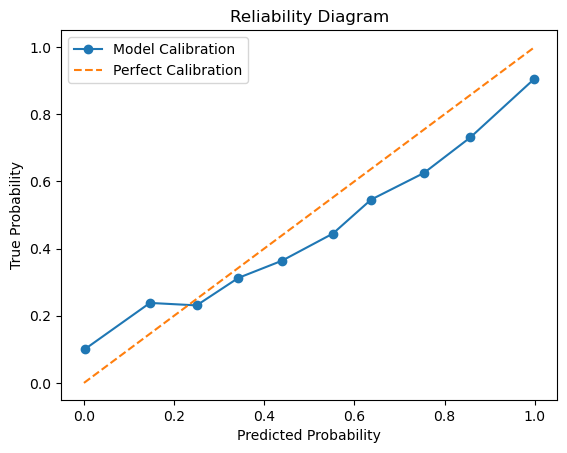

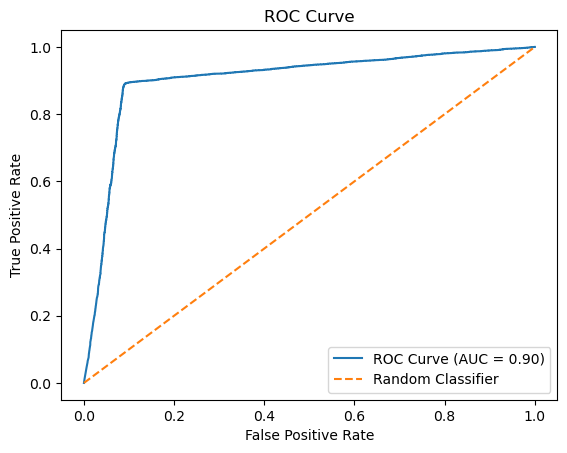

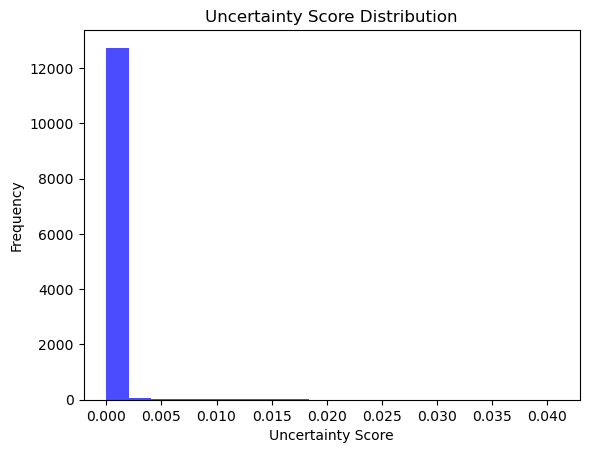

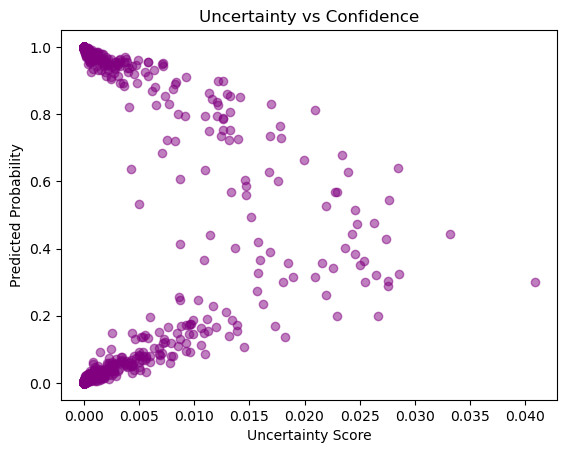

In [13]:
# Assuming labels, probability_scores, and uncertainty_scores are available
analysis = BinaryClassificationAnalysis(pipeline.hard_targets.numpy(),
                                        pipeline.probability_scores,
                                        pipeline.uncertainty_scores)

# Calculate metrics
roc_auc = analysis.calculate_roc_auc()
brier_score = analysis.calculate_brier_score()
print(f"ROC AUC: {roc_auc}, Brier Score: {brier_score}")

# Plotting
analysis.plot_reliability_diagram()
analysis.plot_roc_curve()
analysis.plot_uncertainty_distribution()
analysis.plot_uncertainty_vs_confidence()


In [14]:
import pandas as pd

# Assuming the variables labels, fake_labels, probability_scores, and uncertainty_scores are already defined

# Convert each to a list or numpy array if they aren't already in those formats
labels = labels.cpu().numpy() if torch.is_tensor(labels) else labels
fake_labels = fake_labels.cpu().numpy() if torch.is_tensor(fake_labels) else fake_labels
probability_scores = pipeline.probability_scores
uncertainty_scores = pipeline.uncertainty_scores

# Ensure that all components have the same length
assert len(labels) == len(fake_labels) == len(probability_scores) == len(uncertainty_scores), "Mismatched lengths"

# Create the DataFrame
df = pd.DataFrame({
    'labels': labels,
    'fake_labels': fake_labels,
    'probability_scores': probability_scores,
    'uncertainty_scores': uncertainty_scores
})

# Display the DataFrame
df.head()


,labels,fake_labels,probability_scores,uncertainty_scores
0,0,0,0.000060,7.598644e-08
1,0,0,0.000014,1.289661e-08
2,0,0,0.002308,1.166511e-05
3,0,0,0.001375,8.517796e-06
4,1,1,1.000000,3.520886e-11


In [15]:
df[df['uncertainty_scores']>0.002]

,labels,fake_labels,probability_scores,uncertainty_scores
6,0,1,0.389005,0.016853
7,1,1,0.893538,0.004851
23,0,0,0.056280,0.003843
34,0,0,0.129494,0.007280
55,0,0,0.106044,0.014547
...,...,...,...,...
12729,0,0,0.122466,0.007357
12884,0,1,0.117779,0.009261
12889,0,0,0.140298,0.013132
12963,0,1,0.514940,0.024607


In [16]:
# Assuming your DataFrame is named df and has 'predicted_probability' and 'uncertainty_score' columns

# Set thresholds
uncertainty_threshold = 0.002  # Adjust based on your data
high_confidence_threshold = 0.9
low_confidence_threshold = 0.1

# Identify noisy labels
df['high_uncert'] = (df['uncertainty_scores'] > uncertainty_threshold)
df['low_conf'] = ((df['probability_scores'] > low_confidence_threshold) & (df['probability_scores'] < high_confidence_threshold))

# Filter to see only noisy samples
# noisy_labels_df = df[df['is_noisy']]

# # Output or examine noisy labels
# print(noisy_labels_df)


In [17]:
df[df['low_conf']]

,labels,fake_labels,probability_scores,uncertainty_scores,high_uncert,low_conf
6,0,1,0.389005,0.016853,True,True
7,1,1,0.893538,0.004851,True,True
34,0,0,0.129494,0.007280,True,True
55,0,0,0.106044,0.014547,True,True
85,1,1,0.764255,0.017781,True,True
...,...,...,...,...,...,...
12729,0,0,0.122466,0.007357,True,True
12884,0,1,0.117779,0.009261,True,True
12889,0,0,0.140298,0.013132,True,True
12963,0,1,0.514940,0.024607,True,True


In [18]:
sum(df['labels'] != df['fake_labels'])

1300